In [171]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch 
import torch.nn as nn
import torchvision
#import datasets in torchvision
import torchvision.datasets as datasets

#import model zoo in torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import analyze_patches as pa 
import matplotlib as mpl
import os

# Utils

In [172]:
def format_ax(ax, xlabel = '',ylabel = '', title= '', labelsize = 20, y_ticks_format='{:,.0%}', x_ticks_format=None):
    vals = ax.get_yticks()
    if y_ticks_format is not None:
        ax.set_yticklabels([y_ticks_format.format(x) for x in vals])
    vals = ax.get_xticks()
    if x_ticks_format is not None:
        if x_ticks_format =='int':
            ax.set_xticklabels([int(x) for x in vals])
        else:
            ax.set_xticklabels([x_ticks_format.format(x) for x in vals])
    ax.set_xlabel(xlabel, fontsize=labelsize)
    ax.set_ylabel(ylabel, rotation=0,fontsize = 1.5*labelsize)
    ax.yaxis.set_tick_params(labelsize=labelsize)
    ax.xaxis.set_tick_params(labelsize=labelsize)
    ax.set_title(title, size=labelsize)
    ax.yaxis.set_label_coords(-0.15, 0.5)
    #ax.legend()
    
dirname = 'figures/'
#os.makedirs(dirname, exist_ok=True)
save_figs = True
def save(n, ext='.pdf', save_figs=True, **kwargs):
    if save_figs==True:
        kwargs.setdefault('bbox_inches', 'tight')
        kwargs.setdefault('pad_inches', 0)
        kwargs.setdefault('transparent', True)
        plt.savefig(os.path.join(dirname, n + ext), **kwargs)

# Getting data loaders

In [165]:
# arguments
class Struct:
	def __init__(self, **entries):
		self.__dict__.update(entries)
args = {'dataset':'cifar10',
        'no_padding':False,
        'batchsize':512,
        'num_workers':4,
        'padding_mode':'constant',
        'path_train': '/nfs/data/michaela/projects/data/imagenet/imagenet32/out_data_train/',
        'path_test': '/nfs/data/michaela/projects/data/imagenet/imagenet32/out_data_val/',

       }
args = Struct(**args)
# Getting data loaders
trainset, testset, trainset_whitening, trainloader, testloader, trainloader_whitening = pa.load_data(args)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Computing Singular Values of patches

In [166]:
# Computing singular values of 
patch_sizes = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
whitening_regs = np.array([0.00001,0.0001,0.001,0.01,0.1,1.,10.])
all_eigvals = pa.eigvals_patches(trainloader_whitening,patch_sizes,whitening_regs)

# Decay of singular values

No handles with labels found to put in legend.


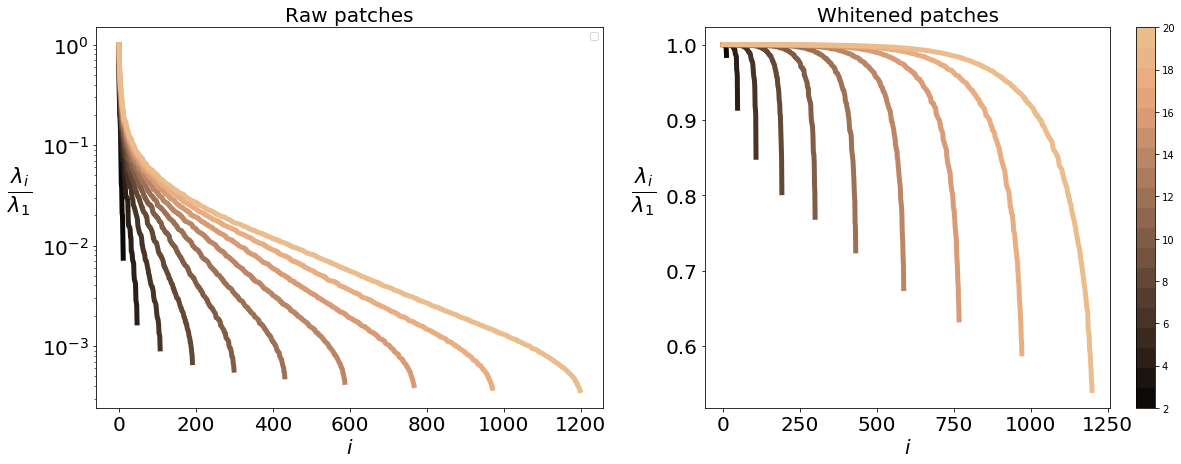

In [174]:
fig, ax = plt.subplots(1,2, figsize=(20,7))
max_id = 200
id_start = 1
raw_idx=0
whitened_idx = 3
linewidth = 5
colors = sns.color_palette("copper", n_colors=len(patch_sizes) , desat=.7)
for i in range(len(patch_sizes)):
    if np.mod(i,2)==0:
        ax[0].plot(np.sqrt(all_eigvals[i][:,raw_idx]),  color= colors[i], linewidth=linewidth)
        ax[1].plot(np.sqrt(all_eigvals[i][:,whitened_idx]) , color= colors[i],linewidth=linewidth)

format_ax(ax[0],xlabel='$i$', ylabel= '$\\frac{\lambda_i}{\lambda_1}$', title = 'Raw patches', labelsize=20, x_ticks_format = None)
format_ax(ax[1],xlabel='$i$', ylabel= '$\\frac{\lambda_i}{\lambda_1}$', title = 'Whitened patches', labelsize=20, x_ticks_format = None)
norm = mpl.colors.Normalize(vmin=2, vmax=patch_sizes[-1], clip=False)
my_cmap = mpl.colors.ListedColormap(colors.as_hex())
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=my_cmap))

ax[0].set_yscale('log') 
ax[1].set_yscale('linear')  
ax[0].legend()
save('spectrum_patches')

# Intrinsic covariance dimension

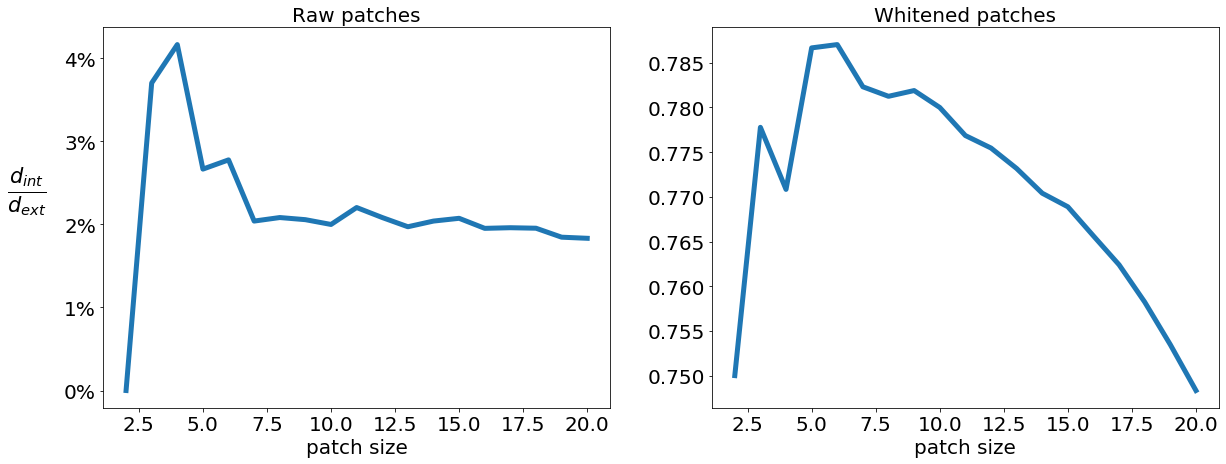

In [175]:
fig, ax = plt.subplots(1,2, figsize=(20,7))
# params
max_id = 100
raw_idx=0
whitened_idx = 3
linewidth = 5.
thresh = 0.2

# computing intrinc dims
all_dims = [ pa.cov_dimension(all_eigvals[i], thresh) for i in range(len(patch_sizes))]
all_dims = np.array(all_dims)

# plot
ax[0].plot(np.array(patch_sizes),all_dims[:,k],label = str(patch_sizes[i]), linewidth = linewidth )
ax[1].plot(np.array(patch_sizes),all_dims[:,kk],label = str(patch_sizes[i]), linewidth = linewidth)

format_ax(ax[0],xlabel='patch size', ylabel= '$\\frac{d_{int}}{d_{ext}}$', title = 'Raw patches', labelsize=20)
format_ax(ax[1],xlabel='patch size', ylabel= '', title = 'Whitened patches', labelsize=20, y_ticks_format=None)

save('intrinsic_dims')